In [ ]:
import cudf
from cuml.linear_model import LinearRegression
from cuml.cluster import KMeans
import numpy as np
import cupy as cp
import pandas as pd
from cuml.preprocessing import StandardScaler
from cuml.linear_model import LogisticRegression
from cuml.metrics import accuracy_score
from google.colab import drive


In [ ]:
!nvidia-smi

Sun Apr 20 12:40:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             50W /  400W |    3443MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
drive.mount('/content/drive')
df = cudf.read_csv("/content/drive/MyDrive/btcusd_1-min_data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()


,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00+00:00


In [ ]:
df.info()


<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 6985166 entries, 0 to 6985165
Data columns (total 7 columns):
 #   Column     Dtype
---  ------     -----
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
 6   datetime   object
dtypes: float64(6), object(1)
memory usage: 508.9+ MB


In [ ]:
df.describe()


,Timestamp,Open,High,Low,Close,Volume
count,6.985166e+06,6.985166e+06,6.985166e+06,6.985166e+06,6.985166e+06,6.985166e+06
mean,1.534967e+09,1.713679e+04,1.714370e+04,1.712966e+04,1.713679e+04,5.318181e+00
std,1.209874e+08,2.369427e+04,2.370232e+04,2.368603e+04,2.369426e+04,2.255904e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.430190e+09,4.230400e+02,4.232100e+02,4.229800e+02,4.230400e+02,1.819100e-02
50%,1.534967e+09,6.551935e+03,6.554430e+03,6.549780e+03,6.551840e+03,4.728120e-01
75%,1.639744e+09,2.707000e+04,2.707500e+04,2.706500e+04,2.707000e+04,3.048188e+00
max,1.744592e+09,1.091110e+05,1.093560e+05,1.087940e+05,1.090360e+05,5.853852e+03


In [ ]:
df.columns

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'datetime'], dtype='object')

In [ ]:
df.shape

(6985166, 7)

In [ ]:
df.isnull().sum()

Timestamp         0
Open              0
High              0
Low               0
Close             0
Volume            0
datetime     202886
dtype: int64

In [ ]:
print(df['Open'].describe())

count    6.985166e+06
mean     1.713679e+04
std      2.369427e+04
min      3.800000e+00
25%      4.230400e+02
50%      6.551935e+03
75%      2.707000e+04
max      1.091110e+05
Name: Open, dtype: float64


In [ ]:
print(df['Volume'].value_counts())

Volume
0.000000    1308912
1.000000      26780
0.500000      11815
0.100000      10960
2.000000      10480
             ...   
0.485605          1
0.116309          1
1.313397          1
3.322453          1
6.538503          1
Name: count, Length: 4915309, dtype: int64


In [ ]:
len(df)

6985166

In [ ]:
df['datetime'] = cudf.to_datetime(df['datetime'].str.replace(r'\+00:00$', ''))


In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00


In [ ]:
#Because cuDF doesnt support timezones I had to remove it.
df['datetime'] = cudf.to_datetime(df['datetime'])

In [ ]:
df.head(6000000)

,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:05:00
...,...,...,...,...,...,...,...
5999995,1.685412e+09,27689.00,27689.00,27688.00,27688.00,0.055679,2023-05-30 01:56:00
5999996,1.685412e+09,27689.00,27689.00,27681.00,27681.00,0.089355,2023-05-30 01:57:00
5999997,1.685412e+09,27678.00,27678.00,27677.00,27677.00,0.750000,2023-05-30 01:58:00
5999998,1.685412e+09,27678.00,27678.00,27678.00,27678.00,0.007840,2023-05-30 01:59:00


In [ ]:
df = df.dropna()

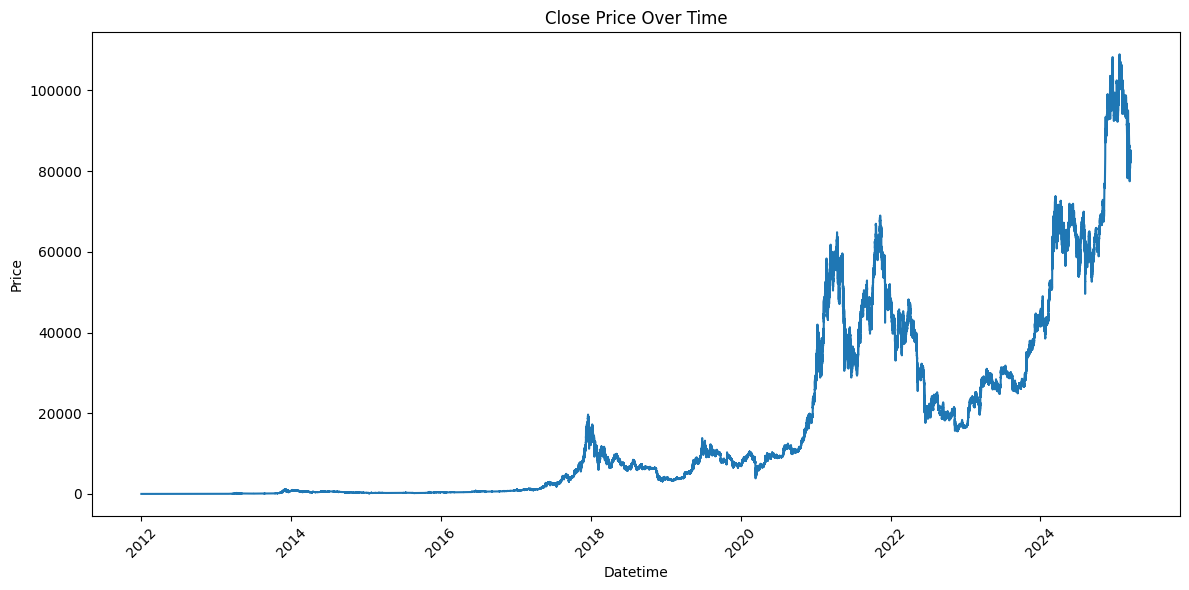

In [ ]:
import matplotlib.pyplot as plt

pdf = df.to_pandas()

plt.figure(figsize=(12, 6))
plt.plot(pdf['datetime'], pdf['Close'])
plt.title('Close Price Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

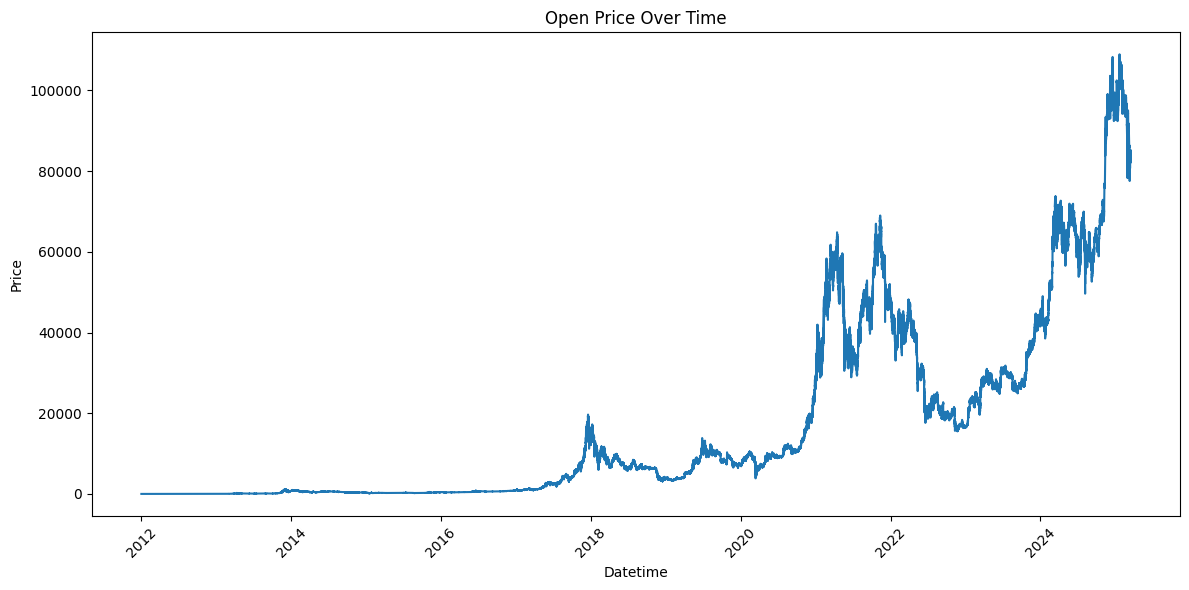

In [ ]:
import matplotlib.pyplot as plt

pdf = df.to_pandas()

plt.figure(figsize=(12, 6))
plt.plot(pdf['datetime'], pdf['Open'])
plt.title('Open Price Over Time')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import cudf
import cupy as cp
import numpy as np



gdf =cudf.read_csv("/content/drive/MyDrive/btcusd_1-min_data.csv")
gdf['Target'] = gdf['Close'].shift(-1)

# Drop the last row since it has no target
gdf = gdf.dropna()

print("Initial cuDF DataFrame:")
print(gdf.head())

features = ['Open', 'High', 'Low', 'Close', 'Volume']
X = gdf[features]
y = gdf['Target']

Initial cuDF DataFrame:
      Timestamp  Open  High   Low  Close  Volume                   datetime  \
0  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:01:00+00:00   
1  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:02:00+00:00   
2  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:03:00+00:00   
3  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:04:00+00:00   
4  1.325412e+09  4.58  4.58  4.58   4.58     0.0  2012-01-01 10:05:00+00:00   

   Target  
0    4.58  
1    4.58  
2    4.58  
3    4.58  
4    4.58  


In [ ]:
from cuml.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler to the features and transform them
X_scaled = scaler.fit_transform(X)

# X_scaled is now a cuDF DataFrame with normalized values
print("\nScaled Features (X_scaled):")
print(X_scaled.head())


Scaled Features (X_scaled):
          0         1         2         3    4
0  0.000007  0.000007  0.000007  0.000007  0.0
1  0.000007  0.000007  0.000007  0.000007  0.0
2  0.000007  0.000007  0.000007  0.000007  0.0
3  0.000007  0.000007  0.000007  0.000007  0.0
4  0.000007  0.000007  0.000007  0.000007  0.0


In [ ]:
from cuml.model_selection import train_test_split

test_size = 0.20
train_size = int(len(X_scaled) * (1 - test_size))

X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(f"\nData Splitting:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Data Splitting:
X_train shape: (5425824, 5)
X_test shape: (1356456, 5)
y_train shape: (5425824,)
y_test shape: (1356456,)


In [ ]:
%%time
from cuml.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=101)

# Train the model
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

from cuml.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")



/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:368: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return init_func(self, *args, **kwargs)


Mean Squared Error: 71194427.06165354
CPU times: user 37.2 s, sys: 11 s, total: 48.2 s
Wall time: 14.2 s


In [ ]:
%%time
y_pred = rf_regressor.predict(X_test)

from cuml.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 71194427.06165354
CPU times: user 412 ms, sys: 1.42 ms, total: 414 ms
Wall time: 49.3 ms


In [ ]:

from cuml.metrics import r2_score, mean_absolute_error



mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 71194427.06165354
R-squared: 0.847213088491243
Mean Absolute Error: 4153.054405271313


In [ ]:
import joblib

joblib.dump(X_test, 'X_test.joblib')

joblib.dump(rf_regressor, 'model.joblib')

joblib.dump(y_pred, 'prediction.joblib')

joblib.dump(scaler, 'scaler.joblib')

print("Data saved successfully!")


Data saved successfully!
